# Simple Waveform

following [this tutorial](https://www.pythonforengineers.com/audio-and-digital-signal-processingdsp-in-python/)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x126f9dcf8>)

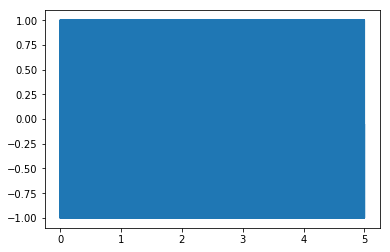

In [33]:
%matplotlib inline
import wave
import struct 

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import kplr
import celerite
from celerite import terms

frequency = 440 * u.Hz
sampling_rate = 48000 * u.Hz 
duration = 5 * u.s
num_samples = int(duration * sampling_rate)

# The sampling rate of the analog to digital convert

amplitude = 20000
file = "test.wav"

x = np.arange(0, num_samples)
sine_wave = np.sin(2 * np.pi * float(frequency/sampling_rate) * x)

@u.quantity_input(sampling_rate=u.Hz)
def write_wave(waveform, num_samples, sampling_rate, path='test.wav'):
    nframes=num_samples
    comptype = "NONE"
    compname = "not compressed" 
    nchannels = 1
    sampwidth = 2 

    fig, ax = plt.subplots()
    ax.plot(np.arange(len(waveform))/sampling_rate.value, waveform)

    with wave.open(path, 'w') as wav_file:
        wav_file.setparams((nchannels, sampwidth, int(sampling_rate.value), nframes, comptype, compname))
        wav_file.writeframes(struct.pack(len(waveform)*'h', *(waveform*amplitude).astype(int).tolist()))
    return fig, ax 

def light_curve(koi): 
    client = kplr.API()

    # Find the target KOI.
    koi = client.koi(koi + 0.01) #Kepler-17

    # Get a list of light curve datasets.
    lcs = koi.get_light_curves(short_cadence=False)

    # Loop over the datasets and read in the data.
    time, flux, ferr, quality = [], [], [], []
    for lc in lcs:
        with lc.open() as f:
            # The lightcurve data are in the first FITS HDU.
            hdu_data = f[1].data
            t = hdu_data["time"]
            f = hdu_data["sap_flux"]
            not_nan = ~np.isnan(f) & ~np.isnan(t)
            fit = np.polyval(np.polyfit(t[not_nan], f[not_nan], 2), t[not_nan])
            time.append(t[not_nan])
            flux.append(f[not_nan]/fit)
            ferr.append(hdu_data["sap_flux_err"])
            quality.append(hdu_data["sap_quality"])
    return time, flux

def gp_interpolate(time, flux): 
    kernel = terms.SHOTerm(log_S0=0, log_omega0=1, log_Q=1/np.sqrt(2))
    gp = celerite.GP(kernel)
    gp.compute(time)

    from scipy.optimize import minimize

    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(flux, gp)) #  bounds=bounds, 
    gp.set_parameter_vector(r.x)

    x = np.linspace(time.min(), time.max(), 10000)
    predicted_flux = gp.predict(flux, x, return_cov=False)
    return x, predicted_flux

write_wave(sine_wave, num_samples, sampling_rate)

# Trappist-1

In [20]:
from astropy.io import fits

d = fits.getdata('data/nPLDTrappist.fits')

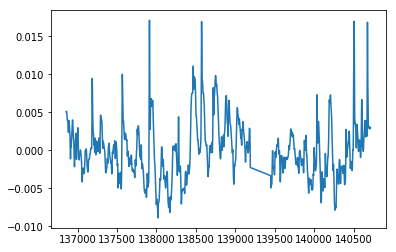

In [21]:
from scipy.ndimage import gaussian_filter1d

time, flux = d['CADN'], d['FLUX']

flux /= flux.mean()

condition = (flux > 0.9) & (flux < 1.1) & (~np.isnan(flux)) & (~np.isnan(time))
fit = np.polyval(np.polyfit(time[condition], flux[condition], 3), time[condition])
time = time[condition]
flux = flux[condition] - fit

flux = gaussian_filter1d(flux, 3)

plt.plot(time, flux)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12c1e97f0>)

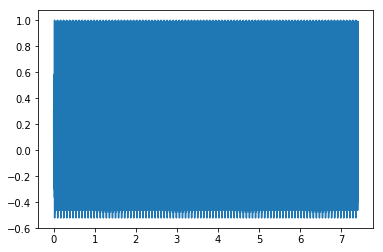

In [22]:
flux = np.tile(flux / flux.max(), 100)

write_wave(flux, len(flux), sampling_rate)

# Kepler-62

In [23]:
time, flux = light_curve(701)
time = np.concatenate(time)
flux = np.concatenate(flux)
flux -= flux.mean()

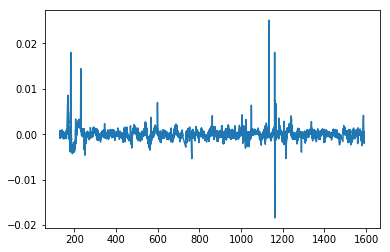

In [24]:
plt.plot(time, flux)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12d3faa20>)

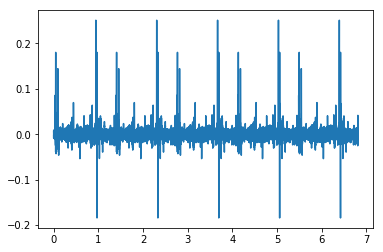

In [25]:
flux = np.tile(flux, 5)
write_wave(10*flux, len(flux), sampling_rate, path='k62.wav')

# Kepler-296

In [26]:
time, flux = light_curve(1422)
time = np.concatenate(time)
flux = np.concatenate(flux)
flux -= flux.mean()

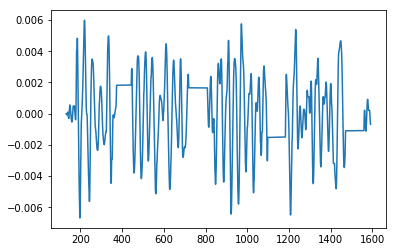

In [27]:
from scipy.ndimage import gaussian_filter1d

flux = gaussian_filter1d(flux, 100)
plt.plot(time, flux)

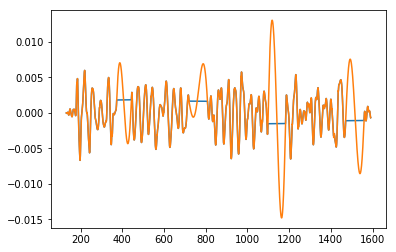

In [28]:
plt.plot(time, flux)

x, predicted_flux = gp_interpolate(time, flux)
plt.plot(x, predicted_flux)

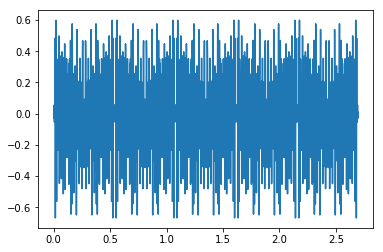

In [29]:
flux = np.tile(np.concatenate([flux, flux[::-1]]), 5)
fig, ax = write_wave(100*flux[::2], len(flux[::2]), sampling_rate*2, path='k296.wav')

# predicted_flux = np.tile(np.concatenate([predicted_flux, predicted_flux[::-1]]), 5)
# fig, ax = write_wave(100*predicted_flux, len(predicted_flux), sampling_rate*2, path='k296.wav')

# Kepler-17

In [34]:
time, flux = light_curve(203)
time = np.concatenate(time)
flux = np.concatenate(flux)
flux -= flux.mean()

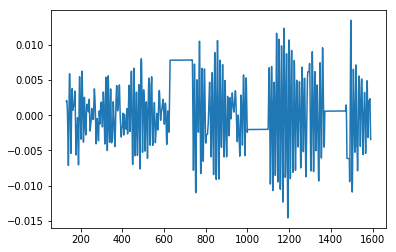

In [35]:
from scipy.ndimage import gaussian_filter1d

flux = gaussian_filter1d(flux, 100)
plt.plot(time, flux)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/celerite/terms.py:500: RuntimeWarning: invalid value encountered in double_scalars
  0.5*w0/Q*np.array([1.0-f, 1.0+f])


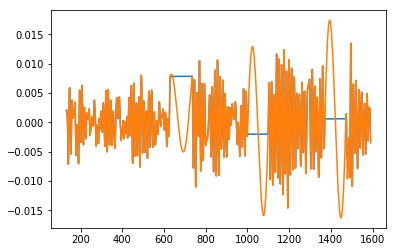

In [36]:
plt.plot(time, flux)

x, predicted_flux = gp_interpolate(time, flux)

plt.plot(x, predicted_flux)

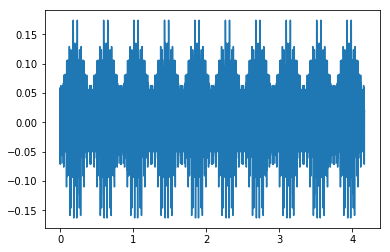

In [37]:
predicted_flux = np.tile(np.concatenate([predicted_flux, predicted_flux[::-1]]), 10)
fig, ax = write_wave(10*predicted_flux, len(predicted_flux), sampling_rate, path='k17.wav')

In [38]:
# flux = np.tile(np.concatenate([flux, flux[::-1]]), 5)
# fig, ax = write_wave(100*flux[::2], len(flux[::2]), sampling_rate*2, path='k17.wav')